In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import h5py
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [2]:
# initialize constants (SI units)
c = 0.299792458 #speed of light
# set pure spectral properties
lambda_0 = 0.8  # central wavelength
tau_0 = 15  # FL pulse duration 1/e2 intensity half-width (same def as beam waist)
# frequency properties
omega_0 = 2*np.pi*c/lambda_0
delta_omega = 2/tau_0
# set beam waist
w_0 = 4
# calculate Rayleigh range
z_R = (omega_0*w_0**2)/(2*c)
# perturbation parameter
eps = w_0/z_R

In [3]:
t_start = -5*tau_0
t_end = 5*tau_0
n = 20
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
omega = np.linspace(1,n*omega_0,num_t)
omega_step = omega[1]-omega[0]
time = np.fft.fftshift(np.fft.fftfreq(num_t,omega_step/(2*np.pi)))
dt = time[1]-time[0]

z = np.array([0, 5*z_R])
r = np.linspace(-15*w_0, 15*w_0, 1201)

temp = xr.DataArray(np.zeros([len(r), len(z), len(omega)]),
                   coords=[r, z, omega],
                   dims=['r', 'z', 'omega'])

pulse_env = np.exp(-((temp.coords['omega']-omega_0)/delta_omega)**2)
fft_norm_coeff = np.sqrt(len(omega))*omega_step/(delta_omega*np.sqrt(np.pi))

pulse_prep = pulse_env*np.exp(1j*temp.coords['omega']*temp.coords['z']/c)
phi_G = np.arctan(temp.coords['z']/z_R)
w = w_0*np.sqrt(1+(temp.coords['z']/z_R)**2)
R = temp.coords['z'] + (z_R**2)/(temp.coords['z'])
phi_norm = -(temp.coords['omega']/c)*(temp.coords['z']+(temp.coords['r']**2)/(2*R))
trans = np.exp(-(temp.coords['r']/w)**2)

c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
c_3 = (w_0/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))

rho = temp.coords['r']/w_0

E_z_spec = trans*pulse_prep*((c_2 - c_3*rho**2)*eps**2)
E_z_spec = E_z_spec.transpose('r', 'z', 'omega')
E_z_time = np.fft.fftshift(np.fft.ifft(E_z_spec, norm='ortho'), axes=2)*fft_norm_coeff
E_z_time = xr.DataArray(E_z_time,
                        coords=[r, z, time],
                        dims=['r', 'z', 'time'])

E_r_spec = trans*pulse_prep*((c_2*rho)*eps)*np.exp(+1j*np.pi/2)
E_r_spec = E_r_spec.transpose('r', 'z', 'omega')
E_r_time = np.fft.fftshift(np.fft.ifft(E_r_spec, norm='ortho'), axes=2)*fft_norm_coeff
E_r_time = xr.DataArray(E_r_time,
                        coords=[r, z, time],
                        dims=['r', 'z', 'time'])

#B_t_spec = trans*pulse_prep*((c_2*rho)*eps)*np.exp(+1j*np.pi/2)/c
#B_t_spec = B_t_spec.transpose('r', 'z', 'omega')
#B_t_time = np.fft.fftshift(np.fft.ifft(B_t_spec, norm='ortho'), axes=2)*fft_norm_coeff
#B_t_time = xr.DataArray(B_t_time,
#                        coords=[r, z, time],
#                        dims=['r', 'z', 'time'])

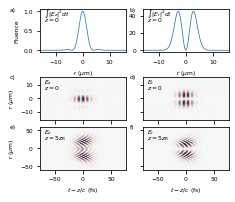

In [23]:
# Define figure dimensions
fig_width = 8.6/2.54  # width in inches
fig_height = 7.5/2.54       # height in inches
fig_size = [fig_width, fig_height]
# tell matplotlib to use latex font rendering
plt.rc('text', usetex=False)
# adjust fontsize
plt.rcParams.update({'font.size' : 6,
          'axes.labelsize' : 6,
          'legend.fontsize': 6,
          'xtick.labelsize' : 6,
          'ytick.labelsize' : 6,
          'lines.linewidth'   : 0.75,
          'lines.markersize'   : 2})
# adjust resolution
plt.rcParams['savefig.dpi'] = 600

fig = plt.figure(figsize = fig_size)
gs = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, height_ratios=[1, 0.25, 1, 1])

max_z = np.max((np.abs(E_z_time)**2).sel(z=0, method='nearest').sum(dim='time'))
max_I_z = np.max((np.abs(E_z_time)**2).sel(z=0, method='nearest'))

ax1 = plt.subplot(gs[0, 0])
((np.abs(E_z_time)**2).sel(z=0, method='nearest').sum(dim='time')/max_z).plot()
plt.xlim(-4*w_0, 4*w_0)

ax3 = plt.subplot(gs[2, 0])
np.real(E_z_time).sel(z=0, method='nearest').plot(add_colorbar=False)
#plt.xlim(-2*tau_0, 2*tau_0)
plt.ylim(-4*w_0, 4*w_0)

ax5 = plt.subplot(gs[3, 0])
np.real(E_z_time).sel(z=5*z_R, method='nearest').plot(add_colorbar=False)
#plt.xlim(-2*tau_0, 2*tau_0)
#plt.ylim(-4*w_0, 4*w_0)

ax2 = plt.subplot(gs[0, 1])
((np.abs(E_r_time)**2).sel(z=0, method='nearest').sum(dim='time')/max_z).plot()
plt.xlim(-4*w_0, 4*w_0)

ax4 = plt.subplot(gs[2, 1])
np.real(E_r_time).sel(z=0, method='nearest').plot(add_colorbar=False)
#plt.xlim(-2*tau_0, 2*tau_0)
plt.ylim(-4*w_0, 4*w_0)

ax6 = plt.subplot(gs[3, 1])
np.real(E_r_time).sel(z=5*z_R, method='nearest').plot(add_colorbar=False)
#plt.xlim(-2*tau_0, 2*tau_0)
#plt.ylim(-4*w_0, 4*w_0)

ax3.set_xlabel('')
ax3.set_xticklabels([])
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax6.set_ylabel('')
ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')
ax6.set_yticklabels([])

ax1.set_xlabel(r'r ($\mu$m)')
ax2.set_xlabel(r'r ($\mu$m)')
ax5.set_xlabel(r'$t-z/c$ (fs)')
ax6.set_xlabel(r'$t-z/c$ (fs)')
ax1.set_ylabel(r'Fluence')
ax3.set_ylabel(r'r ($\mu$m)')
ax5.set_ylabel(r'r ($\mu$m)')

ax1.text(0.05, 0.85, r'$\int{|E_z|^2}dt$', transform=ax1.transAxes)
ax2.text(0.05, 0.85, r'$\int{|E_r|^2}dt$', transform=ax2.transAxes)
ax3.text(0.05, 0.85, r'$E_z$', transform=ax3.transAxes)
ax4.text(0.05, 0.85, r'$E_r$', transform=ax4.transAxes)
ax5.text(0.05, 0.85, r'$E_z$', transform=ax5.transAxes)
ax6.text(0.05, 0.85, r'$E_r$', transform=ax6.transAxes)

ax1.text(0.05, 0.7, r'$z=0$', transform=ax1.transAxes)
ax2.text(0.05, 0.7, r'$z=0$', transform=ax2.transAxes)
ax3.text(0.05, 0.7, r'$z=0$', transform=ax3.transAxes)
ax4.text(0.05, 0.7, r'$z=0$', transform=ax4.transAxes)
ax5.text(0.05, 0.7, r'$z=5z_R$', transform=ax5.transAxes)
ax6.text(0.05, 0.7, r'$z=5z_R$', transform=ax6.transAxes)

ax1.text(-0.35, 0.95, 'a)', transform=ax1.transAxes)
ax2.text(-0.15, 0.95, 'b)', transform=ax2.transAxes)
ax3.text(-0.35, 0.95, 'c)', transform=ax3.transAxes)
ax4.text(-0.15, 0.95, 'd)', transform=ax4.transAxes)
ax5.text(-0.35, 0.95, 'e)', transform=ax5.transAxes)
ax6.text(-0.15, 0.95, 'f)', transform=ax6.transAxes)

#plt.savefig('report/figures/RPLB_standard.png')